
📸 000135.jpg
감지된 아이템: ['belt', 'shoe', 'shoe', 'shoe', 'sleeve', 'top, t-shirt, sweatshirt', 'shoe']
🧥 스타일 분류 결과: 미니멀


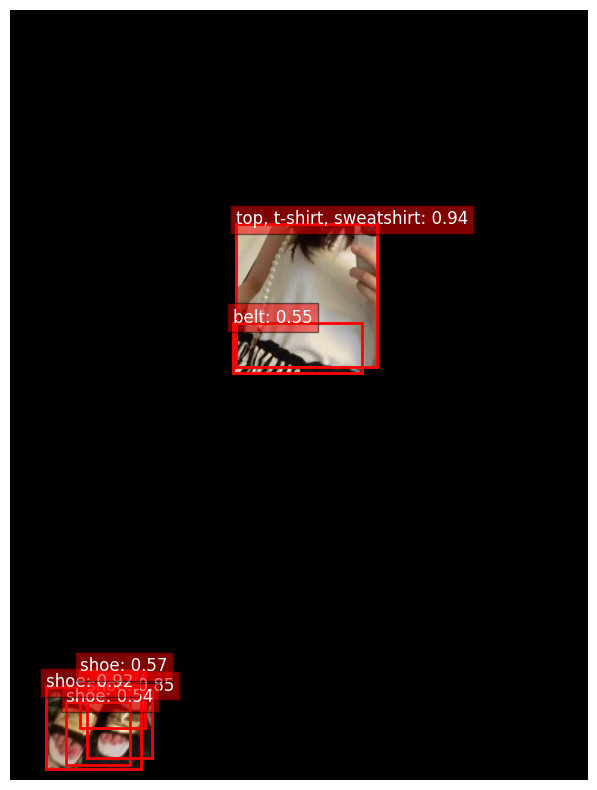


📸 image.png
감지된 아이템: ['bag, wallet', 'belt', 'bag, wallet', 'shoe', 'collar', 'shoe', 'coat', 'collar', 'sleeve', 'skirt', 'sleeve', 'bag, wallet', 'shoe', 'coat']
🧥 스타일 분류 결과: 맥시멀


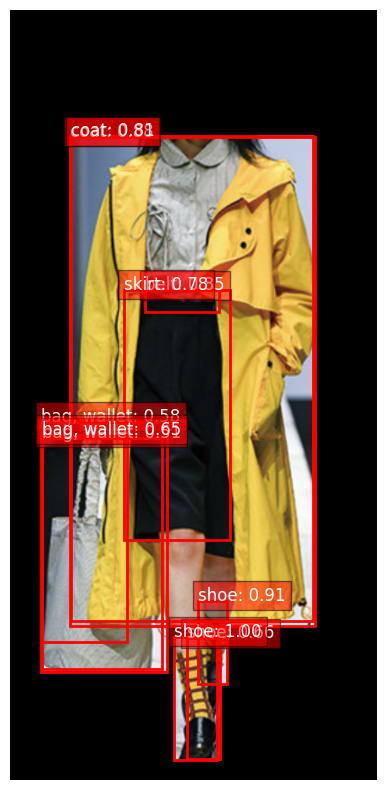


📸 MEN-Denim-id_00000080-01_7_additional_png.rf.675251e8c0c606a8d73e24bc8db49c02.jpg
감지된 아이템: ['shoe', 'shoe', 'shoe', 'neckline', 'sleeve', 'pants', 'sleeve', 'top, t-shirt, sweatshirt']
🧥 스타일 분류 결과: 미니멀


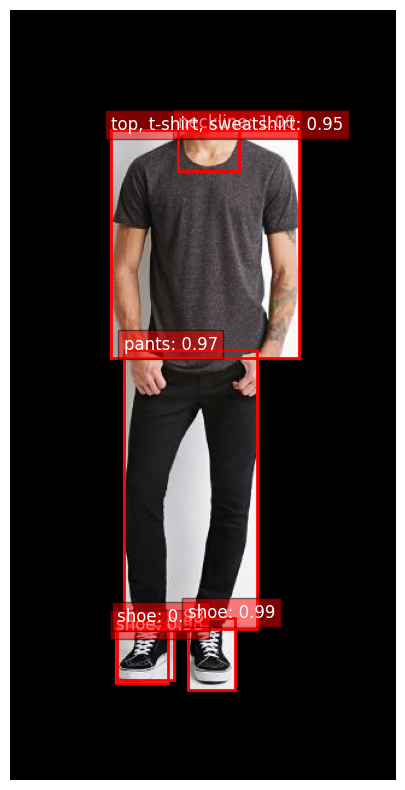

In [ ]:
import os
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from transformers import AutoImageProcessor, YolosForObjectDetection

# 1. 모델 및 프로세서 로딩
processor = AutoImageProcessor.from_pretrained("valentinafeve/yolos-fashionpedia")
model = YolosForObjectDetection.from_pretrained("valentinafeve/yolos-fashionpedia")

# 2. 스타일 분류 함수 (YOLOS 클래스 인덱스 기반)
def classify_style(result):
    # 악세사리로 정의한 클래스 인덱스
    accessory_ids = {
    13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
    24, 25, 26, 34, 35, 36, 37, 38, 39,
    40, 41, 42, 43, 44, 45
    }
    acc_count = sum(1 for label_id in result["labels"] if label_id.item() in accessory_ids)
    return "맥시멀" if acc_count >= 2 else "미니멀"

# 3. YOLOS 박스 기준으로 외곽 마스킹
def apply_mask_outside_boxes(image_path, results):
    image = cv2.imread(image_path)
    h, w, _ = image.shape
    mask = np.zeros((h, w), dtype=np.uint8)

    for label, box in zip(results["labels"], results["boxes"]):
        if label.item() == 31:
            continue  # sleeve 마스킹 제외
        if label.item() == 28:  # collar 제외
            continue
        x1, y1, x2, y2 = map(int, box.tolist())
        cv2.rectangle(mask, (x1, y1), (x2, y2), 255, thickness=-1)

    masked_image = cv2.bitwise_and(image, image, mask=mask)
    return cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
# 4. 디텍션 시각화
def visualize_detection(image_path, results, masked_image):
    plt.figure(figsize=(10, 10))
    plt.imshow(masked_image)
    ax = plt.gca()

    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        label_id = label.item()
        if label_id == 31:  # sleeve 제외
            continue
        if label.item() == 28: # collar 제외
            continue

        box = [round(i, 2) for i in box.tolist()]
        x, y, w, h = box[0], box[1], box[2] - box[0], box[3] - box[1]
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        label_text = f"{model.config.id2label[label_id]}: {score:.2f}"
        ax.text(x, y, label_text, fontsize=12, color='white', bbox=dict(facecolor='red', alpha=0.5))

    plt.axis("off")
    plt.show()

# 5. 예측 실행 및 결과 시각화
def predict_and_visualize(image_path):
    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)

    target_sizes = torch.tensor([image.size[::-1]])
    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.5)[0]

    # 스타일 분류 (← 인덱스 기반으로)
    style = classify_style(results)

    # 라벨 텍스트 리스트도 출력용으로 따로 생성
    label_names = [model.config.id2label[label.item()] for label in results["labels"]]

    print(f"\n📸 {os.path.basename(image_path)}")
    print(f"감지된 아이템: {label_names}")
    print(f"🧥 스타일 분류 결과: {style}")

    # 외곽 마스킹 후 시각화
    masked_image = apply_mask_outside_boxes(image_path, results)
    visualize_detection(image_path, results, masked_image)

# 6. 메인 실행
if __name__ == "__main__":
    image_folder = r"C:/Users/minseong/Desktop/fashion_test/ClothingParts_v1i_yolov11/train/images"
    image_files = [f for f in os.listdir(image_folder) if f.lower().endswith((".jpg", ".png", ".jpeg"))]

    for filename in image_files[:3]:  # 상위 3개만 테스트
        image_path = os.path.join(image_folder, filename)
        predict_and_visualize(image_path)


In [10]:

# 클래스 라벨 출력
labels = model.config.id2label

# 전체 라벨 출력
for idx, name in labels.items():
    print(f"{idx}: {name}")



0: shirt, blouse
1: top, t-shirt, sweatshirt
2: sweater
3: cardigan
4: jacket
5: vest
6: pants
7: shorts
8: skirt
9: coat
10: dress
11: jumpsuit
12: cape
13: glasses
14: hat
15: headband, head covering, hair accessory
16: tie
17: glove
18: watch
19: belt
20: leg warmer
21: tights, stockings
22: sock
23: shoe
24: bag, wallet
25: scarf
26: umbrella
27: hood
28: collar
29: lapel
30: epaulette
31: sleeve
32: pocket
33: neckline
34: buckle
35: zipper
36: applique
37: bead
38: bow
39: flower
40: fringe
41: ribbon
42: rivet
43: ruffle
44: sequin
45: tassel
